### Evaluating Tenure (in months) and Procedures

This notebook creates a pivot-like dataframe where each row defines a provider tenure in months and procedure with the corresponding count. 

The dataframe is then used to generate descriptive statistics, hex bin charts, and histograms of the data.

##### The intermediate dataset <I>ProceduresPatients</I> is being utilized

In [1]:
# import the libraries needed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#import os, time
#print(os.getcwd())

# Edit the file name to make sure you are pointing to the right file.
dfPatProc = pd.read_csv(r'../data/03_processed/ProceduresPatients-20210225-ems-raw-v04.csv', 
                        na_values=['NA'])

dfPatProc.shape

(170072, 19)

In [3]:
# list the columns in the dataframe
dfPatProc.columns

Index(['Unnamed: 0', 'PatientId', 'FRDPersonnelID', 'PatientOutcome',
       'PatientGender', 'DispatchTime', 'FRDPersonnelGender',
       'FRDPersonnelStartDate', 'Dim_Procedure_PK', 'Procedure_Performed_Code',
       'Procedure_Performed_Description', '_PK', 'TenureMonths',
       'PatientOutcomeCode', 'PatientGenderCode', 'PatientGender_Female',
       'PatientGender_Male', 'PatientGender_Unknown (Unable to Determine)',
       'ProviderGenderCode'],
      dtype='object')

Confirm that the procedure description and procedure code counts match.

In [4]:
# check unique procedure description count
print('Procedure Description Count = '+str(dfPatProc.Procedure_Performed_Description.nunique()))

Procedure Description Count = 68


In [5]:
# check unique procedure code count
print('Procedure Code Count = '+str(dfPatProc.Procedure_Performed_Code.nunique()))

Procedure Code Count = 67


As there are 67 unique procedures codes and 68 unique procedure descriptions, there must be a code with two descriptions.

In [6]:
# check that the procedure descriptions listed are unique
#print('Procedure Description ( Unique ) =\n '+str(dfPatProc.Procedure_Performed_Description.unique()))

In [7]:
# find the procedure code(s) with more than one description
dblCheck = dfPatProc[['Procedure_Performed_Code',
                  'Procedure_Performed_Description']].groupby('Procedure_Performed_Code',).nunique()

dblCheck[(dblCheck['Procedure_Performed_Description'] > 1)]

,Procedure_Performed_Description
Procedure_Performed_Code,
427753009,2


In [8]:
# get the descriptions associated with the Procedure Code
procCode =  427753009   # is there a way to collect the value from dblCheck? 

dfPatProc[(dfPatProc['Procedure_Performed_Code'] == procCode)].Procedure_Performed_Description.unique()


array(['Airway - Supraglottic Airway (King, i-Gel)',
       'Airway - Supraglottic Airway (i-Gel, King)'], dtype=object)

Now that the descriptions have been found, they can be reset to be a common value of "Airway - Supraglottic Airway" instead of "Airway - Supraglottic Airway (King, i-Gel)" and "Airway - Supraglottic Airway (i-Gel, King)"

In [9]:
dfPatProc.replace(to_replace=['Airway - Supraglottic Airway (King, i-Gel)','Airway - Supraglottic Airway (i-Gel, King)'],
                  value='Airway - Supraglottic Airway',
                  inplace=True)

Confirm that the unique procedure count now matches the procedure code count of 67.

In [10]:
# get unique procedure count
print('Procedure Description Count = '+str(dfPatProc.Procedure_Performed_Description.nunique()))

Procedure Description Count = 67


Create a pivot-like dataframe using tenure, procedure code and procedure description to get a procedures performed count break down by tenure and procedure.

In [11]:
dfPatProc_pvt = dfPatProc.groupby(['TenureMonths',
                                    'Procedure_Performed_Code',
                                    'Procedure_Performed_Description']).size().to_frame(name='Procedure_Count').reset_index()

dfPatProc_pvt.shape

(8810, 4)

In [12]:
dfPatProc_pvt.head(2)

,TenureMonths,Procedure_Performed_Code,Procedure_Performed_Description,Procedure_Count
0,-27,398041008,MS - Cervical Spinal Restriction of Motion,1
1,-20,7443007,Airway - Oropharyngeal Insertion,1


In [13]:
dfPatProc_pvt.tail(2)

,TenureMonths,Procedure_Performed_Code,Procedure_Performed_Description,Procedure_Count
8808,440,425447009,Resp - Assist Ventilation - BVM Via Mask,2
8809,453,392230005,IV Start - Extremity Vein (arm or leg),1


In [14]:
dfPatProc_pvt.columns

Index(['TenureMonths', 'Procedure_Performed_Code',
       'Procedure_Performed_Description', 'Procedure_Count'],
      dtype='object')

Generate a hex bin plot using tenure and procedure code from dfPatProc as the x and y values, respectively.

<function matplotlib.pyplot.show(close=None, block=None)>

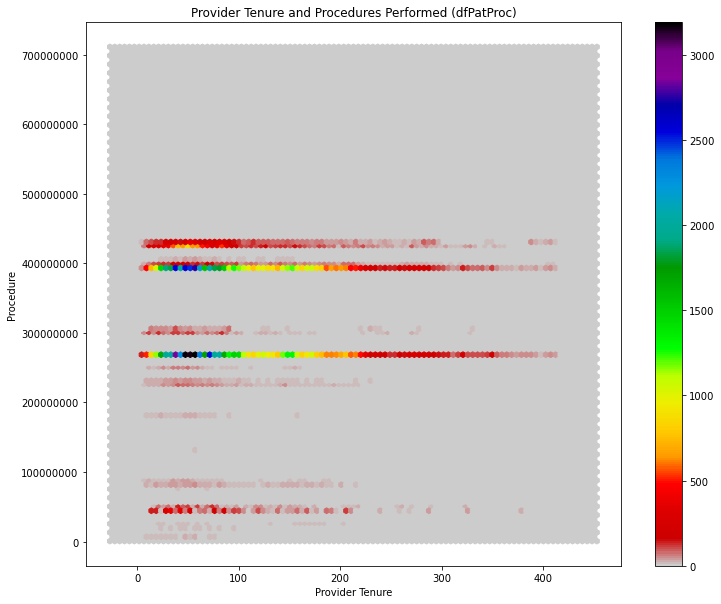

In [15]:
# in order to get the procedure code to show in the y-axis, need to format the values as strings instead of numbers
hb = dfPatProc.plot.hexbin(x='TenureMonths', 
                       y='Procedure_Performed_Code', 
                       gridsize=100,
                       cmap="nipy_spectral_r",
                       #cmap="viridis",
                       xlabel="Provider Tenure",
                       ylabel="Procedure",
                       title="Provider Tenure and Procedures Performed (dfPatProc)",
                       figsize=(12,10),
                       sharex=False)

plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:.0f}'))

plt.show

Now, generate a hex bin plot using tenure, procedure code, and procedure count from dfPatProc_pvt as the x, y and C values, respectively.

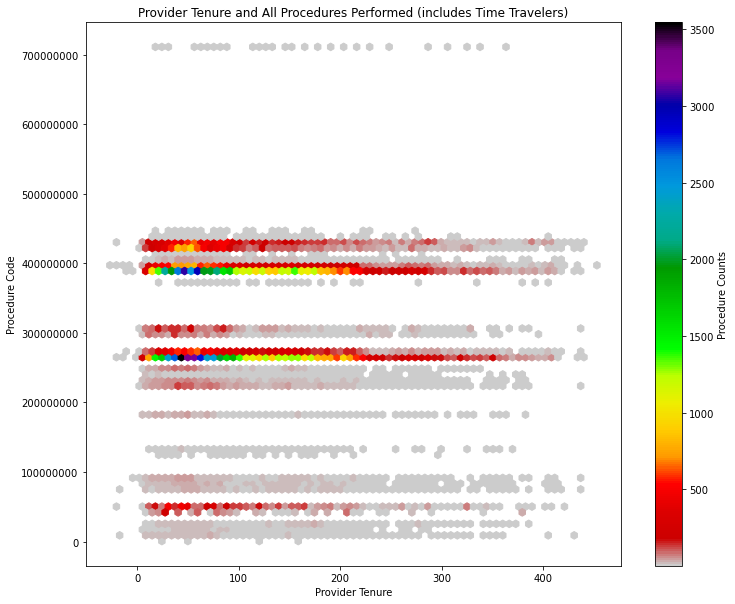

In [16]:
fig, axs = plt.subplots(figsize=(12, 10))
ax = axs
hb1 = ax.hexbin(    x = dfPatProc_pvt["TenureMonths"], 
                    y = dfPatProc_pvt["Procedure_Performed_Code"], 
                    C = dfPatProc_pvt["Procedure_Count"],
                    reduce_C_function=np.sum, 
                    gridsize=75, 
                    cmap="nipy_spectral_r"
                    #sharex=False)
               )
ax.set_title("Provider Tenure and All Procedures Performed (includes Time Travelers)")
ax.set_xlabel("Provider Tenure")
ax.set_ylabel("Procedure Code")
cb = fig.colorbar(hb1, ax=ax)
cb.set_label('Procedure Counts')

plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:.0f}'))
plt.show()

The hex bin plots of dfPatProc and dfPatProc_pvt show the same binning results.  The difference is that the binning of dfPatProc_pvt makes use of 3 attributes from the dataframe.  Using x, y, and C means that the reduce_C_function now comes into play and it is the reason for all of the white showing - it is where there is no sum to show.

Using dfPatProc_pvt, generate descriptive statistics about the tenure, procedure count, and procedure description attributes.

In [17]:
dfPatProc_pvt[['TenureMonths','Procedure_Count']].describe()

,TenureMonths,Procedure_Count
count,8810.000000,8810.000000
mean,152.577639,19.304427
std,102.994886,66.200814
min,-27.000000,1.000000
25%,66.000000,1.000000
50%,137.000000,3.000000
75%,220.000000,7.000000
max,453.000000,697.000000


In [18]:
dfPatProc_pvt[['Procedure_Performed_Description']].describe(include='all')

,Procedure_Performed_Description
count,8810
unique,67
top,IV Start - Extremity Vein (arm or leg)
freq,424


Generate histograms of the tenure and procedures performed using all records from dfPatProc

array([[<AxesSubplot:title={'center':'TenureMonths'}>]], dtype=object)

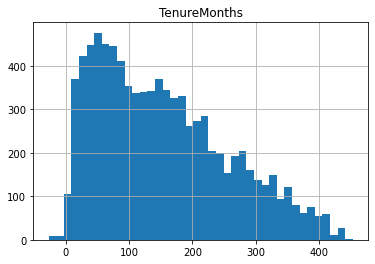

In [19]:
dfPatProc_pvt.hist(column='TenureMonths',
                    bins=40)

array([[<AxesSubplot:title={'center':'Procedure_Performed_Code'}>]],
      dtype=object)

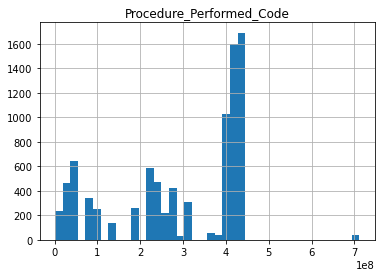

In [20]:
dfPatProc_pvt.hist(column='Procedure_Performed_Code', bins=40)

It has been determined that there are some "time traveler" tenure values - records where the porvider start date is <b>after</b> the dispatch date resulting in a negative value for the calculated provider tenure.

Going to drop the "time traveler" (negative tenure) rows and rerun the hexbin plot and desriptive statistics.

In [21]:
# shape of dfPatProc_pvt that contains all records, including "time traveler" ones
dfPatProc_pvt.shape

(8810, 4)

In [22]:
# create the dfPatProc_pvt2 dataframe by only including those records that have a positive tenure
dfPatProc_pvt2 = dfPatProc_pvt[(dfPatProc_pvt['TenureMonths'] >= 0)]

dfPatProc_pvt2.shape

(8793, 4)

Comparing the two shape sizes, it can be seen that there were 17 "time traveler" rows

Now, rerun the hexbin plot.

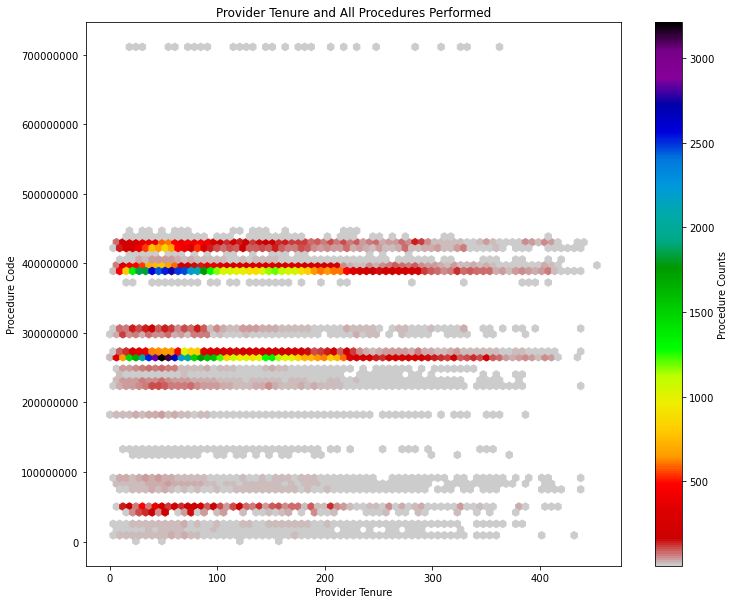

In [23]:
fig, axs = plt.subplots(figsize=(12, 10))
ax = axs
hb1 = ax.hexbin(    x = dfPatProc_pvt2["TenureMonths"], 
                    y = dfPatProc_pvt2["Procedure_Performed_Code"], 
                    C = dfPatProc_pvt2["Procedure_Count"],
                    reduce_C_function=np.sum, 
                    gridsize=75, 
                    cmap="nipy_spectral_r"
                    #sharex=False)
               )
ax.set_title("Provider Tenure and All Procedures Performed")
ax.set_xlabel("Provider Tenure")
ax.set_ylabel("Procedure Code")
cb = fig.colorbar(hb1, ax=ax)
cb.set_label('Procedure Counts')

plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:.0f}'))
plt.show()

Rerun descriptive statistics and histograms to see what difference including the "time traveler" tenure rows incurred.

In [24]:
dfPatProc_pvt2[['TenureMonths','Procedure_Count']].describe()

,TenureMonths,Procedure_Count
count,8793.000000,8793.000000
mean,152.901285,19.339361
std,102.830456,66.260006
min,0.000000,1.000000
25%,66.000000,1.000000
50%,137.000000,3.000000
75%,220.000000,7.000000
max,453.000000,697.000000


In [25]:
dfPatProc_pvt2[['Procedure_Performed_Description']].describe(include='all')

,Procedure_Performed_Description
count,8793
unique,67
top,IV Start - Extremity Vein (arm or leg)
freq,421


array([[<AxesSubplot:title={'center':'TenureMonths'}>]], dtype=object)

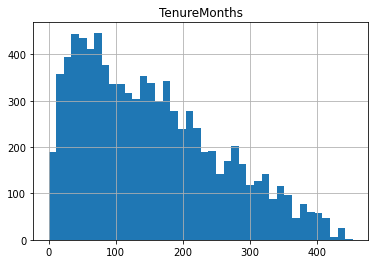

In [26]:
dfPatProc_pvt2.hist(column='TenureMonths', bins=40)

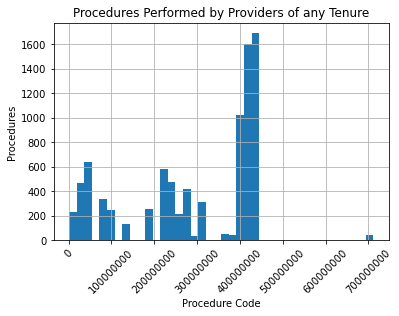

In [27]:
#dfPatProc_pvt2.hist(column='Procedure_Performed_Code', bins=40)

fig,ax=plt.subplots()
ax.hist(x=dfPatProc_pvt2['Procedure_Performed_Code'],bins=40)
ax.set_xlabel('Procedure Code')
ax.set_ylabel('Procedures')
ax.set_title('Procedures Performed by Providers of any Tenure')
ax.ticklabel_format(style='plain')
ax.grid()
plt.xticks(rotation=45)
plt.show()

#### What are the top 10 procedures overall?

In [28]:
dfPatProc_pvt2.groupby(["Procedure_Performed_Code",
                        "Procedure_Performed_Description"])[["Procedure_Count"]].sum().nlargest(10,["Procedure_Count"])

,,Procedure_Count
Procedure_Performed_Code,Procedure_Performed_Description,
268400002,CV - ECG - 12 Lead Obtained,66972
392230005,IV Start - Extremity Vein (arm or leg),59835
46825001,Electrocardiographic monitoring,4755
398041008,MS - Cervical Spinal Restriction of Motion,4693
422618004,Assess - Assessment of Patient,4192
302789003,Assess - Blood Glucose Level (BGL),3590
428803005,CV - ECG - Limb Lead Monitoring,3114
425543005,Assess - Capnography (ETCO2),2876
430824005,IO Start - Intraosseous Access,1857


Based on the tenure histogram, the highest tenure count is around the 50 month value.  Now going to look at provider tenure values less than or equal to 100 months to see what can be found around this "high" point.

In [29]:
# create a dataframe for repeated use in analysis
dfPatProc_p2_lte100 = dfPatProc_pvt2[(dfPatProc_pvt2['TenureMonths'] <= 100)]
dfPatProc_p2_lte100.shape

(3361, 4)

Generate the respective descriptive statistics and histograms.

In [30]:
#dfPatProc_pvt2[(dfPatProc_pvt2['TenureMonths'] <= 100)][['TenureMonths','Procedure_Count']].describe()
dfPatProc_p2_lte100[['TenureMonths','Procedure_Count']].describe()

,TenureMonths,Procedure_Count
count,3361.000000,3361.000000
mean,52.940494,29.905980
std,26.465938,94.333732
min,0.000000,1.000000
25%,31.000000,2.000000
50%,53.000000,4.000000
75%,75.000000,11.000000
max,100.000000,697.000000


In [31]:
dfPatProc_p2_lte100[['Procedure_Performed_Description']].describe(include='all')

,Procedure_Performed_Description
count,3361
unique,67
top,CV - ECG - 12 Lead Obtained
freq,101


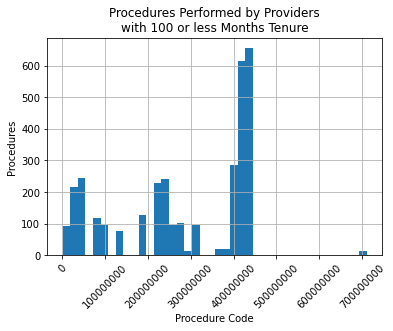

In [32]:
#dfPatProc_p2_lte100.hist(column='Procedure_Performed_Code', bins=40)

fig,ax=plt.subplots()
ax.hist(x=dfPatProc_p2_lte100['Procedure_Performed_Code'],bins=40)
ax.set_xlabel('Procedure Code')
ax.set_ylabel('Procedures')
ax.set_title('Procedures Performed by Providers\nwith 100 or less Months Tenure')
ax.ticklabel_format(style='plain')
ax.grid()
plt.xticks(rotation=45)
plt.show()

A comparison of the procedures performed histograms for all dfPatProc_pvt2 rows and the subset limited to tenure of 100 months or less shows the distribution of procedures is very similar.


#### What are the top 10 procedures by count for procedures performed by providers with 100 or less months of tenure?

In [33]:
dfPatProc_p2_lte100.groupby(['Procedure_Performed_Code',
     'Procedure_Performed_Description'])[['Procedure_Count']].sum().nlargest(10,['Procedure_Count'])

,,Procedure_Count
Procedure_Performed_Code,Procedure_Performed_Description,
268400002,CV - ECG - 12 Lead Obtained,39043
392230005,IV Start - Extremity Vein (arm or leg),33944
422618004,Assess - Assessment of Patient,3596
46825001,Electrocardiographic monitoring,3035
398041008,MS - Cervical Spinal Restriction of Motion,2621
302789003,Assess - Blood Glucose Level (BGL),2571
425543005,Assess - Capnography (ETCO2),1998
428803005,CV - ECG - Limb Lead Monitoring,1966
430824005,IO Start - Intraosseous Access,1121


The mean of the tenure values for those providers with 100 months or less, is 52.9 months.

#### What are the top 10 procedures by count for procedures performed by providers with 52 or 53 months (mean = 52.9) of tenure?

In [34]:
dfPatProc_pvt2[(dfPatProc_pvt2['TenureMonths'] >= 52) & 
                (dfPatProc_pvt2['TenureMonths'] <= 53)].groupby(['Procedure_Performed_Code',
                          'Procedure_Performed_Description'])[['Procedure_Count']].sum().nlargest(10,['Procedure_Count'])

,,Procedure_Count
Procedure_Performed_Code,Procedure_Performed_Description,
268400002,CV - ECG - 12 Lead Obtained,1221
392230005,IV Start - Extremity Vein (arm or leg),925
422618004,Assess - Assessment of Patient,164
46825001,Electrocardiographic monitoring,112
428803005,CV - ECG - Limb Lead Monitoring,86
425543005,Assess - Capnography (ETCO2),84
398041008,MS - Cervical Spinal Restriction of Motion,81
302789003,Assess - Blood Glucose Level (BGL),58
225358003,Wound Care - General,39


Now going to look at procedures of the highest (greater than or equal to 300 months) and lowest (less than or equal to 24 months) tenure values.

In [35]:
# how many rows include provider tenure less than or equal to 24 months or greater than or equal to 300 months
#dfPatProc_pvt2[(dfPatProc_pvt2['TenureMonths'] <= 24) | (dfPatProc_pvt2['TenureMonths'] >= 300)].shape

# create dataframe for future analysis
dfPatProc_p2_lte24 = dfPatProc_pvt2[(dfPatProc_pvt2['TenureMonths'] <= 24)]
dfPatProc_p2_lte24.shape

(611, 4)

Run descriptive statitics for those providers with less than or equal to 24 months of tenure.

In [36]:
dfPatProc_p2_lte24[['TenureMonths','Procedure_Count']].describe()

,TenureMonths,Procedure_Count
count,611.000000,611.000000
mean,14.998363,18.034370
std,5.860258,52.781552
min,0.000000,1.000000
25%,10.000000,2.000000
50%,16.000000,4.000000
75%,20.000000,9.000000
max,24.000000,405.000000


In [37]:
dfPatProc_p2_lte24[['Procedure_Performed_Description']].describe(include='all')

,Procedure_Performed_Description
count,611
unique,55
top,CV - ECG - 12 Lead Obtained
freq,25


In [38]:
dfPatProc_p2_lte24.groupby(['Procedure_Performed_Code',
                          'Procedure_Performed_Description'])[['Procedure_Count']].sum().nlargest(10,['Procedure_Count'])

,,Procedure_Count
Procedure_Performed_Code,Procedure_Performed_Description,
268400002,CV - ECG - 12 Lead Obtained,3992
392230005,IV Start - Extremity Vein (arm or leg),3478
302789003,Assess - Blood Glucose Level (BGL),555
398041008,MS - Cervical Spinal Restriction of Motion,362
46825001,Electrocardiographic monitoring,336
422618004,Assess - Assessment of Patient,266
425543005,Assess - Capnography (ETCO2),229
425447009,Resp - Assist Ventilation - BVM Via Mask,206
428803005,CV - ECG - Limb Lead Monitoring,162


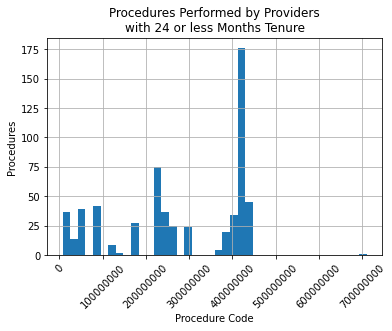

In [39]:
#dfPatProc_pvt2[(dfPatProc_pvt2['TenureMonths'] <= 24)].hist(column='Procedure_Performed_Code', bins=40)

fig,ax=plt.subplots()
ax.hist(x=dfPatProc_p2_lte24['Procedure_Performed_Code'],bins=40)
ax.set_xlabel('Procedure Code')
ax.set_ylabel('Procedures')
ax.set_title('Procedures Performed by Providers\nwith 24 or less Months Tenure')
ax.ticklabel_format(style='plain')
ax.grid()
plt.xticks(rotation=45)
plt.show()

Again, the distribution of procedures performed by providers with less than or equal to 24 months of tenure is similar to the distribution seen across all records.

In [40]:
# create dataframe for future analysis
dfPatProc_p2_gte300 = dfPatProc_pvt2[(dfPatProc_pvt2['TenureMonths'] >= 300)]
dfPatProc_p2_gte300.shape

(955, 4)

Run descriptive statitics for those providers with greater than or equal to 300 months of tenure.

In [41]:
dfPatProc_p2_gte300[['TenureMonths','Procedure_Count']].describe()

,TenureMonths,Procedure_Count
count,955.000000,955.000000
mean,351.373822,5.213613
std,35.859520,7.909500
min,300.000000,1.000000
25%,322.000000,1.000000
50%,346.000000,1.000000
75%,379.000000,5.000000
max,453.000000,58.000000


In [42]:
dfPatProc_p2_gte300[['Procedure_Performed_Description']].describe(include='all')

,Procedure_Performed_Description
count,955
unique,49
top,IV Start - Extremity Vein (arm or leg)
freq,126


In [43]:
dfPatProc_p2_gte300.groupby(['Procedure_Performed_Code',
                          'Procedure_Performed_Description'])[['Procedure_Count']].sum().nlargest(10,['Procedure_Count'])

,,Procedure_Count
Procedure_Performed_Code,Procedure_Performed_Description,
268400002,CV - ECG - 12 Lead Obtained,2110
392230005,IV Start - Extremity Vein (arm or leg),1434
428803005,CV - ECG - Limb Lead Monitoring,239
398041008,MS - Cervical Spinal Restriction of Motion,155
422618004,Assess - Assessment of Patient,146
46825001,Electrocardiographic monitoring,125
302789003,Assess - Blood Glucose Level (BGL),106
426498007,MS - Full Spinal Restriction of Motion,88
426220008,CV - Defibrillation - Manual,67


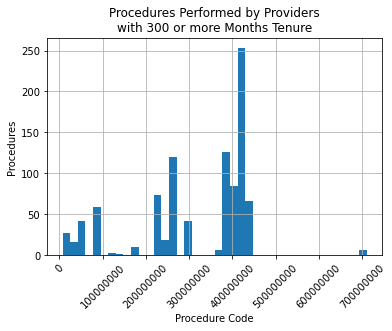

In [44]:
#dfPatProc_pvt2[(dfPatProc_pvt2['TenureMonths'] >= 300)].hist(column='Procedure_Performed_Code', bins=40)

fig,ax=plt.subplots()
ax.hist(x=dfPatProc_p2_gte300['Procedure_Performed_Code'],bins=40)
ax.set_xlabel('Procedure Code')
ax.set_ylabel('Procedures')
ax.set_title('Procedures Performed by Providers\nwith 300 or more Months Tenure')
ax.ticklabel_format(style='plain')
ax.grid()
plt.xticks(rotation=45)
plt.show()

The procedures performed histogram for providers with greater than or equal to 300 months of tenure continues to display a similar distribution of procedures perfomred.

Show all of the procedure performed histograms together so can see the similarity in shape

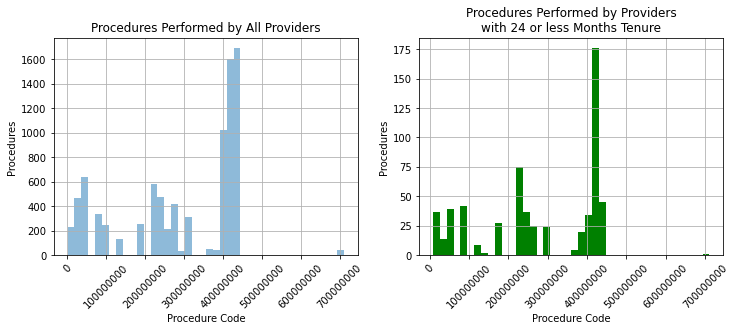

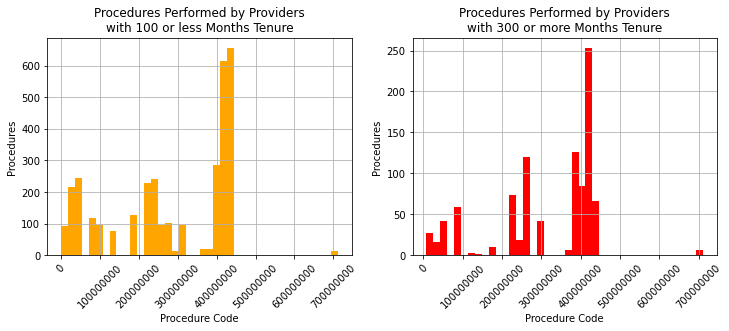

In [45]:
# show procedure histograms from 24, 100, and 300 side by side

fig=plt.figure(figsize=(12,4))

# all tenure
ax1=plt.subplot(121)
ax1.hist(x=dfPatProc_pvt2['Procedure_Performed_Code'],bins=40, alpha = 0.5)
ax1.set_xlabel('Procedure Code')
ax1.set_ylabel('Procedures')
ax1.set_title('Procedures Performed by All Providers')
ax1.ticklabel_format(style='plain')
ax1.grid()
plt.xticks(rotation=45)

# lte 24 months tenure
ax2=plt.subplot(122)
ax2.hist(x=dfPatProc_p2_lte24['Procedure_Performed_Code'], bins=40, color='green')
ax2.set_xlabel('Procedure Code')
ax2.set_ylabel('Procedures')
ax2.set_title('Procedures Performed by Providers\nwith 24 or less Months Tenure')
ax2.ticklabel_format(style='plain')
ax2.grid()
plt.xticks(rotation=45)

# show the first 2 plots
plt.show()

fig=plt.figure(figsize=(12,4))

# lte 100 months tenure
ax1=plt.subplot(121)
ax1.hist(x=dfPatProc_p2_lte100['Procedure_Performed_Code'], bins=40, color='orange')
ax1.set_xlabel('Procedure Code')
ax1.set_ylabel('Procedures')
ax1.set_title('Procedures Performed by Providers\nwith 100 or less Months Tenure')
ax1.ticklabel_format(style='plain')
ax1.grid()
plt.xticks(rotation=45)

# gte 300 months tenure
ax2=plt.subplot(122)
ax2.hist(x=dfPatProc_p2_gte300['Procedure_Performed_Code'], bins=40, color='red')
ax2.set_xlabel('Procedure Code')
ax2.set_ylabel('Procedures')
ax2.set_title('Procedures Performed by Providers\nwith 300 or more Months Tenure')
ax2.ticklabel_format(style='plain')
ax2.grid()
plt.xticks(rotation=45)

# show all the plots
plt.show()

Show the histograms as overlays so can see the comparison on the same scale

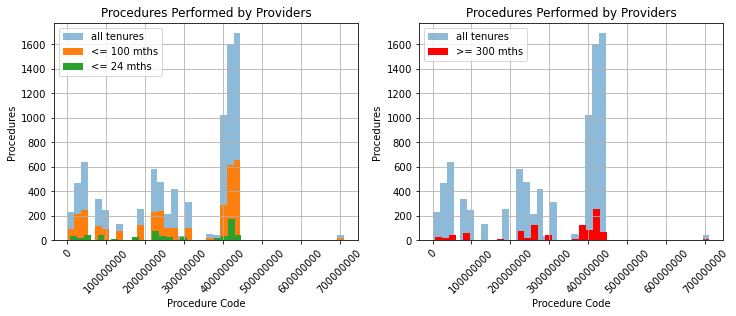

In [46]:
fig=plt.figure(figsize=(12,4))

#fig=plt.figure(figsize=(12,4))
#fig,ax=plt.subplots()

ax1=plt.subplot(121)
ax1.hist(x=dfPatProc_pvt2['Procedure_Performed_Code'], bins=40, alpha=0.5, label='all tenures')
ax1.hist(x=dfPatProc_p2_lte100['Procedure_Performed_Code'], bins=40,  label='<= 100 mths')
ax1.hist(x=dfPatProc_p2_lte24['Procedure_Performed_Code'], bins=40,  label='<= 24 mths')
#ax1.hist(x=dfPatProc_p2_gte300['Procedure_Performed_Code'], bins=40, label='>= 300 mths')
ax1.set_xlabel('Procedure Code')
ax1.set_ylabel('Procedures')
ax1.set_title('Procedures Performed by Providers')
ax1.ticklabel_format(style='plain')
ax1.grid()
plt.xticks(rotation=45)
plt.legend(loc='upper left')

ax2=plt.subplot(122)
ax2.hist(x=dfPatProc_pvt2['Procedure_Performed_Code'], bins=40, alpha=0.5, label='all tenures')
ax2.hist(x=dfPatProc_p2_gte300['Procedure_Performed_Code'], bins=40, label='>= 300 mths', color='red')
#ax1.hist(x=dfPatProc_p2_lte100['Procedure_Performed_Code'], bins=40, alpha=0.5, label='<= 100 mths')
#ax1.hist(x=dfPatProc_p2_lte24['Procedure_Performed_Code'], bins=40, alpha=0.5, label='<= 24 mths')
ax2.set_xlabel('Procedure Code')
ax2.set_ylabel('Procedures')
ax2.set_title('Procedures Performed by Providers')
ax2.ticklabel_format(style='plain')
ax2.grid()
plt.xticks(rotation=45)
plt.legend(loc='upper left')

plt.show()

How does the hexbin plot change when the 2 highest procedure counts are not plotted?

In [47]:
dfPatProc_pvt2.groupby(["Procedure_Performed_Code",
                        "Procedure_Performed_Description"])[["Procedure_Count"]].sum().nlargest(2,["Procedure_Count"])

,,Procedure_Count
Procedure_Performed_Code,Procedure_Performed_Description,
268400002,CV - ECG - 12 Lead Obtained,66972
392230005,IV Start - Extremity Vein (arm or leg),59835


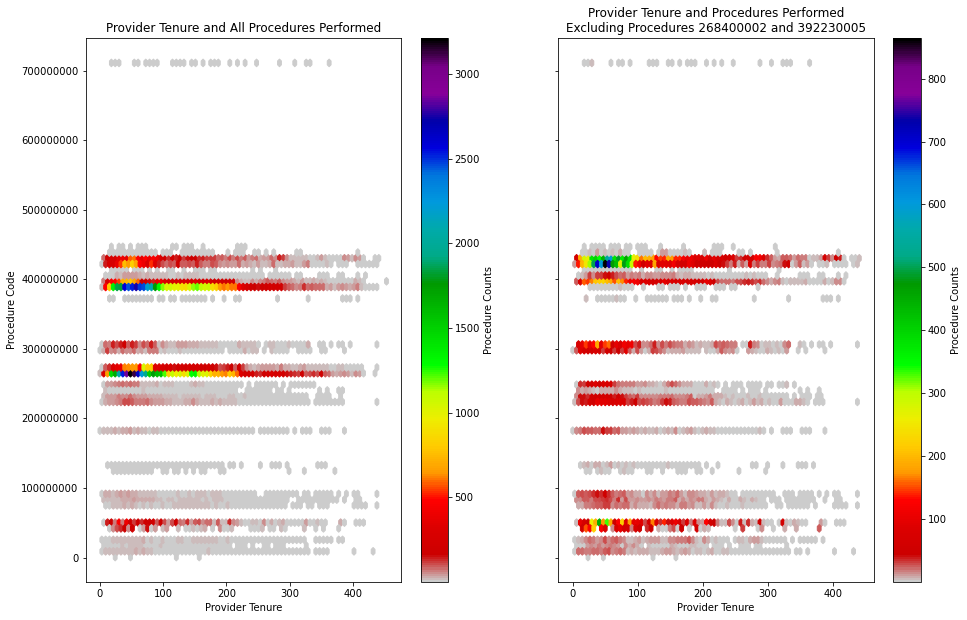

In [48]:
fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(14, 10))
fig.subplots_adjust(hspace=0.5, left=0.07, right=0.93)
ax = axs[0]
hb1 = ax.hexbin(    x = dfPatProc_pvt2["TenureMonths"], 
                    y = dfPatProc_pvt2["Procedure_Performed_Code"], 
                    C = dfPatProc_pvt2["Procedure_Count"],
                    reduce_C_function=np.sum, 
                    gridsize=75, 
                    cmap="nipy_spectral_r", 
                    #xlabel="Provider Tenure", 
                    #ylabel="Procedure Code", 
                    #title="Provider Tenure and All Procedures Performed",
                    #sharex=False)
               )
#ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax))
ax.set_title("Provider Tenure and All Procedures Performed")
ax.set_xlabel("Provider Tenure")
ax.set_ylabel("Procedure Code")
cb = fig.colorbar(hb1, ax=ax)
cb.set_label('Procedure Counts')

ax = axs[1]
hb2 = ax.hexbin(    x = dfPatProc_pvt2[(dfPatProc_pvt2['Procedure_Performed_Code'] != 268400002) &
                        (dfPatProc_pvt2['Procedure_Performed_Code'] != 392230005)]["TenureMonths"],
                    y = dfPatProc_pvt2[(dfPatProc_pvt2['Procedure_Performed_Code'] != 268400002) &
                        (dfPatProc_pvt2['Procedure_Performed_Code'] != 392230005)]["Procedure_Performed_Code"],
                    C = dfPatProc_pvt2[(dfPatProc_pvt2['Procedure_Performed_Code'] != 268400002) &
                        (dfPatProc_pvt2['Procedure_Performed_Code'] != 392230005)]["Procedure_Count"],
                    reduce_C_function=np.sum,
                    gridsize=75,
                    cmap="nipy_spectral_r",
                    #xlabel="Provider Tenure",
                    #ylabel="Procedure Code",
                    #title="Provider Tenure and Procedures Performed",
                    #sharex=False)
               )
#ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax))
ax.set_title("Provider Tenure and Procedures Performed\nExcluding Procedures 268400002 and 392230005")
ax.set_xlabel("Provider Tenure")
cb = fig.colorbar(hb2, ax=ax)
cb.set_label('Procedure Counts')
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:.0f}'))
plt.show()

#### 

Rerun the histograms using 25%, 50%, 75% and 100% of the records, using tenure as the attribute to be sliced

build protocol categories and rerun procedure histograms and descriptive statistics

remove from pvt2 and rerun

reset tenure to be in years

In [49]:
explore whether can define tenure from number of calls - what is the possibility of multi-counting occuring?

Object `occuring` not found.


In [ ]:
explore whether can define tenure from number of calls - what is the possibility of multi-counting occuring